In [15]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import heartpy as hp
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from random import shuffle
from scipy.interpolate import CubicSpline
from numba import jit



# remove the superfluous columns

In [16]:
Y_val = np.load('/media/data1/anolin/Y_val_v1.1.npy').astype(np.int64)
Y_val

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [17]:
og_labels =  ['Sinusal','Regular','Monomorph','QS complex in V1-V2-V3','R complex in V5-V6','T wave inversion (inferior - II, III, aVF)','Left bundle branch block','RaVL > 11 mm','SV1 + RV5 or RV6 > 35 mm','T wave inversion (lateral -I, aVL, V5-V6)','T wave inversion (anterior - V3-V4)','Left axis deviation','Left ventricular hypertrophy','Bradycardia','Q wave (inferior - II, III, aVF)','Afib','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','Nonspecific intraventricular conduction delay','Premature ventricular complex','Polymorph','T wave inversion (septal- V1-V2)','Right bundle branch block','Ventricular paced','ST elevation (anterior - V3-V4)','ST elevation (septal - V1-V2)','1st degree AV block','Premature atrial complex','Atrial flutter',"rSR' in V1-V2",'qRS in V5-V6-I, aVL','Left anterior fascicular block','Right axis deviation','2nd degree AV block - mobitz 1','ST depression (inferior - II, III, aVF)','Acute pericarditis','ST elevation (inferior - II, III, aVF)','Low voltage','Regularly irregular','Bifid','Junctional rhythm','Left atrial enlargement','ST elevation (lateral - I, aVL, V5-V6)','Atrial paced','Right ventricular hypertrophy','Delta wave','Wolff-Parkinson-White (Pre-excitation syndrome)','Prolonged QT','ST depression (anterior - V3-V4)','QRS complex negative in III','RaVL + SV3 > 28 mm (H) or 20 mm (F)','Q wave (lateral- I, aVL, V5-V6)','Hyperacute T wave (lateral, V5-V6)','Hyperacute T wave (septal, V1-V2)','Supraventricular tachycardia','ST downslopping','ST depression (lateral - I, avL, V5-V6)','2nd degree AV block - mobitz 2','U wave','ST depression et T inversion in V5 or V6','Large >0.08 s','R/S ratio in V1-V2 >1','RV1 + SV6\xa0> 11 mm','Left posterior fascicular block','Right atrial enlargement','ST depression (septal- V1-V2)','Q wave (septal- V1-V2)','Q wave (anterior - V3-V4)','Hyperacute T wave (anterior, V3-V4)','ST upslopping','Right superior axis','Auricular bigeminy','Ventricular tachycardia','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Lead misplacement','Biphasic','Ventricular bigeminy','J wave','Tall >2.5 mm','Third Degree AV Block','Sinus Pause','Acute MI','Early repolarization','Q wave (posterior - V7-V9)','Bi-atrial enlargement','LV pacing','Dextrocardia','Brugada','Ventricular Rhythm','ST depression (posterior - V7-V8-V9)','no_qrs']
to_remove_labels = ['ST depression (posterior - V7-V8-V9)','Tall >2.5 mm', 'J wave', 'Auricular bigeminy', 'Ventricular bigeminy', 'Sinus Pause', 'Dextrocardia', 'Hyperacute T wave (lateral, V5-V6)', 'Hyperacute T wave (septal, V1-V2)', 'Hyperacute T wave (anterior, V3-V4)', 'Bifid', 'RaVL + SV3 > 28 mm (H) or 20 mm (F)', 'Large >0.08 s', 'Biphasic', 'ST depression et T inversion in V5 or V6']

pos_to_drop = list()
new_label_names = list()
for pos, item in enumerate(og_labels):
    if item in to_remove_labels:
        pos_to_drop.append(pos)
    else:
        new_label_names.append(item)
Y_val = np.delete(Y_val, pos_to_drop, axis=1)


In [18]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigmoid_v = np.vectorize(sigmoid)

In [19]:
Y_pred = np.load('/volume/my_name/resnet50_standardscaler_leads_42_v1.1/output_1.npy')

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigmoid_v = np.vectorize(sigmoid)
Y_pred = sigmoid_v(Y_pred)
sigmoid_v_bin =  np.where(Y_pred > 0.5, 1, 0)
sigmoid_v_bin

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [20]:
#check shape, should be (149177, 77)
print(Y_val.shape)
print(sigmoid_v_bin.shape)

(149177, 77)
(149177, 77)


In [25]:
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.metrics import precision_recall_curve

dict_results = dict()
for pos, label in enumerate(tqdm(new_label_names)):
    ROC = roc_auc_score(Y_val[:,pos], sigmoid_v_bin[:,pos], average=None)
    precision, recall, thresholds = precision_recall_curve(Y_val[:,pos], sigmoid_v_bin[:,pos])
    PR = auc(recall, precision)

    acc = accuracy_score(Y_val[:,pos], sigmoid_v_bin[:,pos])

    dict_results.update({label:[ROC,PR,acc]})


100%|██████████| 77/77 [00:02<00:00, 26.14it/s]


In [26]:
df_out = pd.DataFrame.from_dict(dict_results).T
df_out.columns = ['ROC','PR','ACC']
df_out

,ROC,PR,ACC
Sinusal,0.955495,0.987925,0.966288
Regular,0.929950,0.989106,0.967689
Monomorph,0.789540,0.981973,0.952667
QS complex in V1-V2-V3,0.858451,0.749948,0.985031
R complex in V5-V6,0.914445,0.822675,0.972710
...,...,...,...
Bi-atrial enlargement,0.638537,0.493534,0.998867
LV pacing,0.500000,0.500399,0.999202
Brugada,0.500000,0.500050,0.999899
Ventricular Rhythm,0.918220,0.829723,0.989207


# this is to get the label frequency from the train set

In [28]:
Y_val_ = np.load('/media/data1/muse_ge/Y_train_v1.1.npy').astype(np.int64)

pos_to_drop = list()
new_label_names = list()
for pos, item in enumerate(og_labels):
    if item in to_remove_labels:
        pos_to_drop.append(pos)
    else:
        new_label_names.append(item)

#print(Y_train.shape)
Y_val_ = np.delete(Y_val_, pos_to_drop, axis=1)


label_counts = np.sum(Y_val_, axis=0)
label_counts/Y_val_.shape[0]

array([7.74878920e-01, 8.61573774e-01, 9.17161810e-01, 3.04563440e-02,
       7.06668540e-02, 1.89498280e-01, 5.95547494e-02, 5.73282016e-02,
       2.66006629e-02, 1.89560183e-01, 8.82090243e-02, 1.60357623e-01,
       1.33299074e-01, 2.05645173e-01, 1.29338255e-01, 9.81577430e-02,
       1.18844200e-01, 5.58415437e-02, 3.10036464e-02, 7.59453248e-02,
       1.85011776e-02, 1.02390739e-01, 9.68125779e-02, 5.43106693e-02,
       1.12830752e-02, 9.50950115e-03, 8.95335549e-02, 4.00621390e-02,
       1.60309476e-02, 4.08187329e-02, 2.22890601e-02, 4.14485727e-02,
       1.69889724e-02, 6.12841069e-03, 1.08527010e-02, 8.48564289e-03,
       1.22204656e-02, 3.47591034e-02, 5.55094284e-02, 1.45600112e-02,
       3.53437442e-02, 8.21248301e-03, 1.92204331e-02, 8.62124024e-03,
       1.45423246e-03, 1.45423246e-03, 5.19111857e-02, 7.79979542e-03,
       1.33584025e-01, 2.87201084e-02, 5.03871894e-03, 9.85782913e-02,
       3.28853053e-02, 1.15061230e-02, 9.94380571e-04, 2.25268468e-02,
      

In [29]:
#add the prevalence to the df
df_out['Prevalence'] = label_counts/Y_val_.shape[0]

In [30]:
#create a label for ease of use in matplotlib
df_out_ = df_out[['ROC','Prevalence']]
df_out_.index = [f'{i} ({"{:.3f}".format(j)})' for i,j in zip(df_out_.index,df_out_.ROC)]

#### Robert final approach (seems finicky with figsize)

Text(0.5, 1.0, 'Distribution of ROC avg 3 seed')

<Figure size 960x160 with 0 Axes>

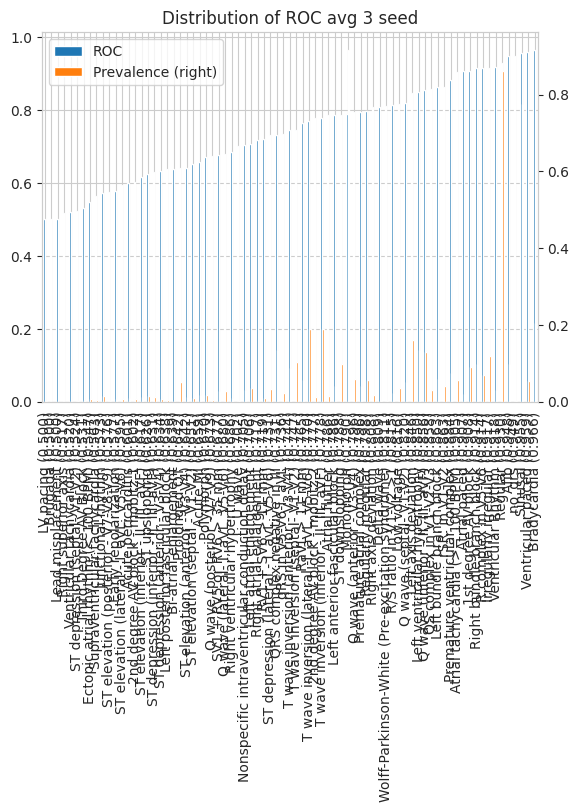

In [34]:
import seaborn as sns
from matplotlib.pyplot import figure
sns.set_style("whitegrid")

figure(figsize=(12, 2), dpi=80)
df_out_.sort_values('ROC').plot( kind= 'bar' , secondary_y= 'Prevalence' )
plt.xticks(rotation=90, fontsize=8)
plt.title('Distribution of ROC avg 3 seed')
#plt.savefig('/volume/core_model/ROC.jpg', dpi=600, bbox_inches="tight")


#### Robert old approach

Text(0, 0.5, 'proportion - PR')

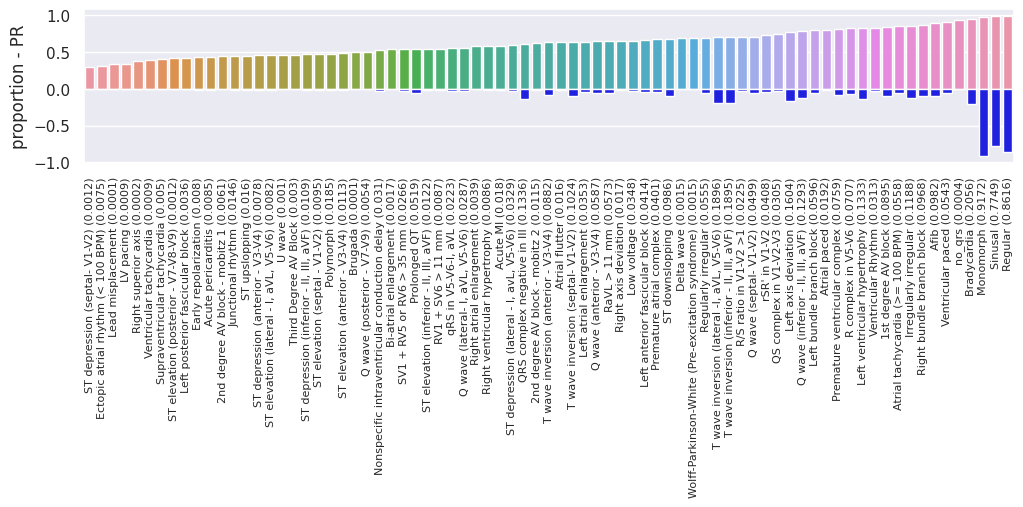

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 2))
ax1=sns.barplot(y=df_out.sort_values('PR', ascending=True)['PR'], x=df_out.sort_values('PR', ascending=True).index)#, ax=ax1)
#ax2 = ax1.twinx()
sns.barplot(x=[f'{i} ({round(j,4)})' for i,j in zip(df_out.sort_values('PR', ascending=True).index,df_out.sort_values('PR', ascending=True)['PR'].values)]  , y=-1*df_out.sort_values('PR', ascending=True)['preponderance'].values,color='blue')#,ax=ax2, color='blue)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('proportion - PR')


### General performance histogram

Text(0.5, 1.0, 'Score distribution')

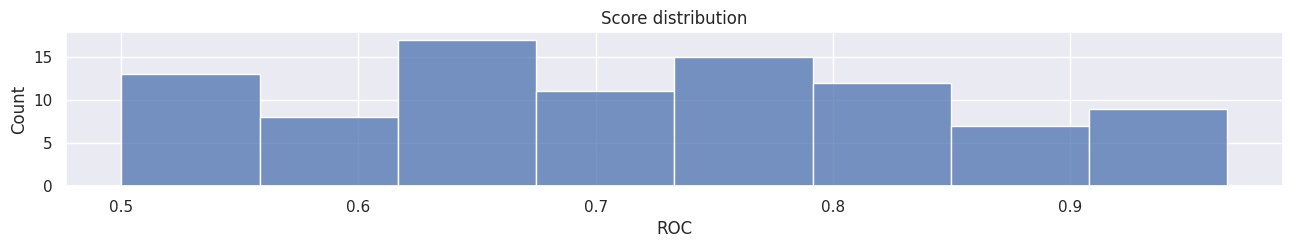

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_out['ROC'])
plt.title("Score distribution")

# first approach without frenquency

In [36]:
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

og_labels =  ['Sinusal','Regular','Monomorph','QS complex in V1-V2-V3','R complex in V5-V6','T wave inversion (inferior - II, III, aVF)','Left bundle branch block','RaVL > 11 mm','SV1 + RV5 or RV6 > 35 mm','T wave inversion (lateral -I, aVL, V5-V6)','T wave inversion (anterior - V3-V4)','Left axis deviation','Left ventricular hypertrophy','Bradycardia','Q wave (inferior - II, III, aVF)','Afib','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','Nonspecific intraventricular conduction delay','Premature ventricular complex','Polymorph','T wave inversion (septal- V1-V2)','Right bundle branch block','Ventricular paced','ST elevation (anterior - V3-V4)','ST elevation (septal - V1-V2)','1st degree AV block','Premature atrial complex','Atrial flutter',"rSR' in V1-V2",'qRS in V5-V6-I, aVL','Left anterior fascicular block','Right axis deviation','2nd degree AV block - mobitz 1','ST depression (inferior - II, III, aVF)','Acute pericarditis','ST elevation (inferior - II, III, aVF)','Low voltage','Regularly irregular','Bifid','Junctional rhythm','Left atrial enlargement','ST elevation (lateral - I, aVL, V5-V6)','Atrial paced','Right ventricular hypertrophy','Delta wave','Wolff-Parkinson-White (Pre-excitation syndrome)','Prolonged QT','ST depression (anterior - V3-V4)','QRS complex negative in III','RaVL + SV3 > 28 mm (H) or 20 mm (F)','Q wave (lateral- I, aVL, V5-V6)','Hyperacute T wave (lateral, V5-V6)','Hyperacute T wave (septal, V1-V2)','Supraventricular tachycardia','ST downslopping','ST depression (lateral - I, avL, V5-V6)','2nd degree AV block - mobitz 2','U wave','ST depression et T inversion in V5 or V6','Large >0.08 s','R/S ratio in V1-V2 >1','RV1 + SV6\xa0> 11 mm','Left posterior fascicular block','Right atrial enlargement','ST depression (septal- V1-V2)','Q wave (septal- V1-V2)','Q wave (anterior - V3-V4)','Hyperacute T wave (anterior, V3-V4)','ST upslopping','Right superior axis','Auricular bigeminy','Ventricular tachycardia','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Lead misplacement','Biphasic','Ventricular bigeminy','J wave','Tall >2.5 mm','Third Degree AV Block','Sinus Pause','Acute MI','Early repolarization','Q wave (posterior - V7-V9)','Bi-atrial enlargement','LV pacing','Dextrocardia','Brugada','Ventricular Rhythm','ST depression (posterior - V7-V8-V9)','no_qrs']
to_remove_labels = ['ST depression (posterior - V7-V8-V9)','Tall >2.5 mm', 'J wave', 'Auricular bigeminy', 'Ventricular bigeminy', 'Sinus Pause', 'Dextrocardia', 'Hyperacute T wave (lateral, V5-V6)', 'Hyperacute T wave (septal, V1-V2)', 'Hyperacute T wave (anterior, V3-V4)', 'Bifid', 'RaVL + SV3 > 28 mm (H) or 20 mm (F)', 'Large >0.08 s', 'Biphasic', 'ST depression et T inversion in V5 or V6']

Y_val = np.load('/media/data1/anolin/Y_val_v1.1.npy').astype(np.int64)

pos_to_drop = list()
new_label_names = list()
for pos, item in enumerate(og_labels):
    if item in to_remove_labels:
        pos_to_drop.append(pos)
    else:
        new_label_names.append(item)

#print(Y_train.shape)
Y_val = np.delete(Y_val, pos_to_drop, axis=1)

dict_results = dict(zip(new_label_names,[[0,0,0] for _ in range(len(new_label_names))]))
for i in [2023,1997,42]:
    Y_pred = np.load(f'/volume/my_name/resnet50_notscaled_{i}_v1.1/output_1.npy')
    Y_pred = sigmoid_v(Y_pred)
    sigmoid_v_bin =  np.where(Y_pred > 0.5, 1, 0)
    

    for pos, label in enumerate(new_label_names):
        try:
            ROC = roc_auc_score(Y_val[:,pos], sigmoid_v_bin[:,pos], average=None)
        except:
            ROC = 0.5
        precision, recall, thresholds = precision_recall_curve(Y_val[:,pos], sigmoid_v_bin[:,pos])
        PR = auc(recall, precision)

        acc = accuracy_score(Y_val[:,pos], sigmoid_v_bin[:,pos])

        dict_results[label][0] += ROC
        dict_results[label][1] += PR
        dict_results[label][2] += acc

for k,v in dict_results.items():
    v[0] = v[0]/3
    v[1] = v[1]/3
    v[2] = v[2]/3
df_out = pd.DataFrame.from_dict(dict_results).T
df_out.columns = ['ROC','PR','ACC']
df_out

,ROC,PR,ACC
Sinusal,0.954154,0.987529,0.966127
Regular,0.929014,0.988961,0.967663
Monomorph,0.799436,0.982774,0.952765
QS complex in V1-V2-V3,0.857744,0.750898,0.985118
R complex in V5-V6,0.906740,0.822988,0.973361
...,...,...,...
Bi-atrial enlargement,0.682237,0.557191,0.998927
LV pacing,0.499997,0.333732,0.999196
Brugada,0.500000,0.500050,0.999899
Ventricular Rhythm,0.918715,0.829144,0.989140


Text(0.5, 1.0, 'Distribution of ACC avg 3 seed')

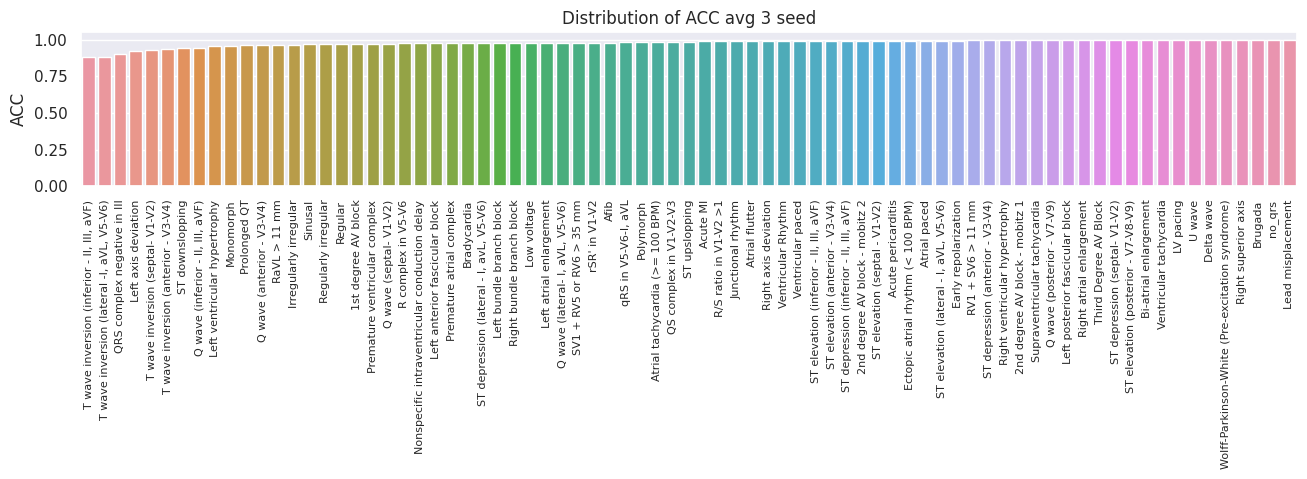

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(15.7,2)})

sns.barplot(y=df_out.sort_values('ACC', ascending=True)['ACC'], x=df_out.sort_values('ACC', ascending=True).index)
plt.xticks(rotation=90, fontsize=8)
plt.title('Distribution of ACC avg 3 seed')

Text(0.5, 1.0, 'Score distribution')

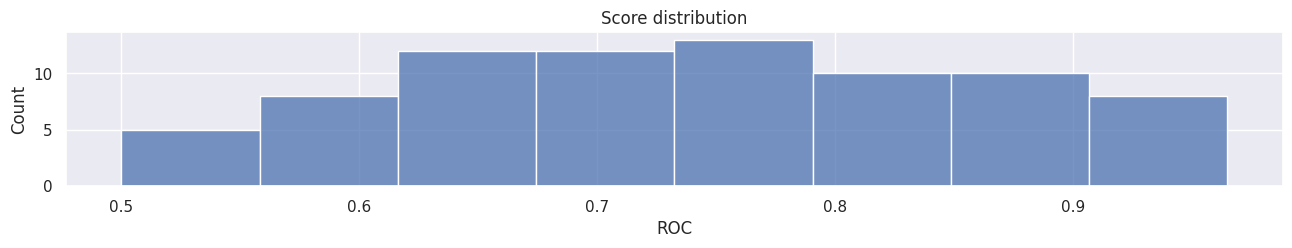

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_out['ROC'])
plt.title("Score distribution")

# test the scaling's impace on the results

In [37]:
Y_val = np.load('/media/data1/anolin/Y_val_v1.1.npy').astype(np.int64)
og_labels =  ['Sinusal','Regular','Monomorph','QS complex in V1-V2-V3','R complex in V5-V6','T wave inversion (inferior - II, III, aVF)','Left bundle branch block','RaVL > 11 mm','SV1 + RV5 or RV6 > 35 mm','T wave inversion (lateral -I, aVL, V5-V6)','T wave inversion (anterior - V3-V4)','Left axis deviation','Left ventricular hypertrophy','Bradycardia','Q wave (inferior - II, III, aVF)','Afib','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','Nonspecific intraventricular conduction delay','Premature ventricular complex','Polymorph','T wave inversion (septal- V1-V2)','Right bundle branch block','Ventricular paced','ST elevation (anterior - V3-V4)','ST elevation (septal - V1-V2)','1st degree AV block','Premature atrial complex','Atrial flutter',"rSR' in V1-V2",'qRS in V5-V6-I, aVL','Left anterior fascicular block','Right axis deviation','2nd degree AV block - mobitz 1','ST depression (inferior - II, III, aVF)','Acute pericarditis','ST elevation (inferior - II, III, aVF)','Low voltage','Regularly irregular','Bifid','Junctional rhythm','Left atrial enlargement','ST elevation (lateral - I, aVL, V5-V6)','Atrial paced','Right ventricular hypertrophy','Delta wave','Wolff-Parkinson-White (Pre-excitation syndrome)','Prolonged QT','ST depression (anterior - V3-V4)','QRS complex negative in III','RaVL + SV3 > 28 mm (H) or 20 mm (F)','Q wave (lateral- I, aVL, V5-V6)','Hyperacute T wave (lateral, V5-V6)','Hyperacute T wave (septal, V1-V2)','Supraventricular tachycardia','ST downslopping','ST depression (lateral - I, avL, V5-V6)','2nd degree AV block - mobitz 2','U wave','ST depression et T inversion in V5 or V6','Large >0.08 s','R/S ratio in V1-V2 >1','RV1 + SV6\xa0> 11 mm','Left posterior fascicular block','Right atrial enlargement','ST depression (septal- V1-V2)','Q wave (septal- V1-V2)','Q wave (anterior - V3-V4)','Hyperacute T wave (anterior, V3-V4)','ST upslopping','Right superior axis','Auricular bigeminy','Ventricular tachycardia','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Lead misplacement','Biphasic','Ventricular bigeminy','J wave','Tall >2.5 mm','Third Degree AV Block','Sinus Pause','Acute MI','Early repolarization','Q wave (posterior - V7-V9)','Bi-atrial enlargement','LV pacing','Dextrocardia','Brugada','Ventricular Rhythm','ST depression (posterior - V7-V8-V9)','no_qrs']
to_remove_labels = ['ST depression (posterior - V7-V8-V9)','Tall >2.5 mm', 'J wave', 'Auricular bigeminy', 'Ventricular bigeminy', 'Sinus Pause', 'Dextrocardia', 'Hyperacute T wave (lateral, V5-V6)', 'Hyperacute T wave (septal, V1-V2)', 'Hyperacute T wave (anterior, V3-V4)', 'Bifid', 'RaVL + SV3 > 28 mm (H) or 20 mm (F)', 'Large >0.08 s', 'Biphasic', 'ST depression et T inversion in V5 or V6']

Y_val = np.load('/media/data1/anolin/Y_val_v1.1.npy').astype(np.int64)

pos_to_drop = list()
new_label_names = list()
for pos, item in enumerate(og_labels):
    if item in to_remove_labels:
        pos_to_drop.append(pos)
    else:
        new_label_names.append(item)
Y_val = np.delete(Y_val, pos_to_drop, axis=1)
Y_val

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [38]:
Y_pred = np.load('/volume/my_name/resnet50_robustscaler_leads_1997_v1.1/output_1.npy')

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigmoid_v = np.vectorize(sigmoid)
Y_pred = sigmoid_v(Y_pred)
sigmoid_v_bin =  np.where(Y_pred > 0.5, 1, 0)
sigmoid_v_bin

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score
import scikit_posthocs as sp
from statistics import mean

In [8]:
def hamming_score(y_true: np.ndarray, y_pred: np.ndarray):
    numerator = (y_true & y_pred).sum(axis=1)
    denominator = (y_true | y_pred).sum(axis=1)

    return np.divide(numerator, denominator, out=np.ones_like(numerator, dtype=np.float_),
                        where=denominator != 0).mean()

Text(0.5, 1.0, 'CDD for Acc')

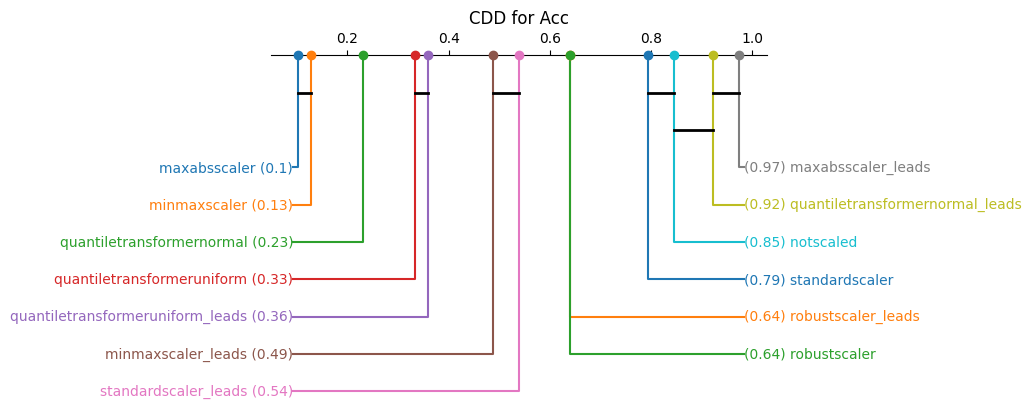

In [16]:
list_condition = list()
list_inter = list()
list_score = list()

metric = 'avg_acc' #['cat_accuracy', 'hamming', 'avg_acc', 'roc_macro', 'roc_micro', 'pr_macro', 'pr_micro']

Y_val = np.load('/media/data1/anolin/Y_val_v1.1.npy').astype(np.int64)
og_labels =  ['Sinusal','Regular','Monomorph','QS complex in V1-V2-V3','R complex in V5-V6','T wave inversion (inferior - II, III, aVF)','Left bundle branch block','RaVL > 11 mm','SV1 + RV5 or RV6 > 35 mm','T wave inversion (lateral -I, aVL, V5-V6)','T wave inversion (anterior - V3-V4)','Left axis deviation','Left ventricular hypertrophy','Bradycardia','Q wave (inferior - II, III, aVF)','Afib','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','Nonspecific intraventricular conduction delay','Premature ventricular complex','Polymorph','T wave inversion (septal- V1-V2)','Right bundle branch block','Ventricular paced','ST elevation (anterior - V3-V4)','ST elevation (septal - V1-V2)','1st degree AV block','Premature atrial complex','Atrial flutter',"rSR' in V1-V2",'qRS in V5-V6-I, aVL','Left anterior fascicular block','Right axis deviation','2nd degree AV block - mobitz 1','ST depression (inferior - II, III, aVF)','Acute pericarditis','ST elevation (inferior - II, III, aVF)','Low voltage','Regularly irregular','Bifid','Junctional rhythm','Left atrial enlargement','ST elevation (lateral - I, aVL, V5-V6)','Atrial paced','Right ventricular hypertrophy','Delta wave','Wolff-Parkinson-White (Pre-excitation syndrome)','Prolonged QT','ST depression (anterior - V3-V4)','QRS complex negative in III','RaVL + SV3 > 28 mm (H) or 20 mm (F)','Q wave (lateral- I, aVL, V5-V6)','Hyperacute T wave (lateral, V5-V6)','Hyperacute T wave (septal, V1-V2)','Supraventricular tachycardia','ST downslopping','ST depression (lateral - I, avL, V5-V6)','2nd degree AV block - mobitz 2','U wave','ST depression et T inversion in V5 or V6','Large >0.08 s','R/S ratio in V1-V2 >1','RV1 + SV6\xa0> 11 mm','Left posterior fascicular block','Right atrial enlargement','ST depression (septal- V1-V2)','Q wave (septal- V1-V2)','Q wave (anterior - V3-V4)','Hyperacute T wave (anterior, V3-V4)','ST upslopping','Right superior axis','Auricular bigeminy','Ventricular tachycardia','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Lead misplacement','Biphasic','Ventricular bigeminy','J wave','Tall >2.5 mm','Third Degree AV Block','Sinus Pause','Acute MI','Early repolarization','Q wave (posterior - V7-V9)','Bi-atrial enlargement','LV pacing','Dextrocardia','Brugada','Ventricular Rhythm','ST depression (posterior - V7-V8-V9)','no_qrs']
to_remove_labels = ['ST depression (posterior - V7-V8-V9)','Tall >2.5 mm', 'J wave', 'Auricular bigeminy', 'Ventricular bigeminy', 'Sinus Pause', 'Dextrocardia', 'Hyperacute T wave (lateral, V5-V6)', 'Hyperacute T wave (septal, V1-V2)', 'Hyperacute T wave (anterior, V3-V4)', 'Bifid', 'RaVL + SV3 > 28 mm (H) or 20 mm (F)', 'Large >0.08 s', 'Biphasic', 'ST depression et T inversion in V5 or V6']

Y_val = np.load('/media/data1/anolin/Y_val_v1.1.npy').astype(np.int64)

pos_to_drop = list()
new_label_names = list()
for pos, item in enumerate(og_labels):
    if item in to_remove_labels:
        pos_to_drop.append(pos)
    else:
        new_label_names.append(item)
Y_val = np.delete(Y_val, pos_to_drop, axis=1)

dict_eq = {42:0,1997:1,2023:2}

for condition in ['notscaled','standardscaler','minmaxscaler','maxabsscaler','robustscaler','quantiletransformeruniform','quantiletransformernormal']:
    for approach in [None,'leads']:
        if approach == 'leads' and condition == 'notscaled':
            continue
        for seed in [42,1997,2023]:
            if approach == None:
                output_matrix = np.load(f'/volume/my_name/resnet50_{condition}_{seed}_v1.1/output_1.npy')
            else:
                if condition != 'notscaled':
                    output_matrix = np.load(f'/volume/my_name/resnet50_{condition}_leads_{seed}_v1.1/output_1.npy')

            def sigmoid(x):
                return 1 / (1 + math.exp(-x))

            sigmoid_v = np.vectorize(sigmoid)
            Y_pred = sigmoid_v(output_matrix)
            sigmoid_v_bin =  np.where(Y_pred > 0.5, 1, 0)
            sigmoid_v_bin


            if approach != None:
                name = f'{condition}_{approach}'

            else:
                name = condition

            if metric == 'cat_accuracy':
                list_condition.append(name)
                list_inter.append(dict_eq[seed])
                list_score.append(accuracy_score(Y_val, sigmoid_v_bin))

            if metric == 'hamming':
                list_condition.append(name)
                list_inter.append(dict_eq[seed])
                list_score.append(accuracy_score(Y_val, sigmoid_v_bin))
            
            if metric == 'avg_acc':
                list_condition.append(name)
                list_inter.append(dict_eq[seed])
                list_score.append(mean([accuracy_score(Y_val[:,i], sigmoid_v_bin[:,i]) for i in range(Y_val.shape[1])]))

            if metric == 'roc_macro':
                list_condition.append(name)
                list_inter.append(dict_eq[seed])
                list_score.append(roc_auc_score(Y_val, sigmoid_v_bin, average='macro'))            
                                  
            if metric == 'roc_micro':
                list_condition.append(name)
                list_inter.append(dict_eq[seed])
                list_score.append(roc_auc_score(Y_val, sigmoid_v_bin, average='micro'))          


            if metric == 'pr_macro':
                list_condition.append(name)
                list_inter.append(dict_eq[seed])
                list_score.append(average_precision_score(Y_val, sigmoid_v_bin, average='macro'))          

            if metric == 'pr_micro':
                list_condition.append(name)
                list_inter.append(dict_eq[seed])
                list_score.append(average_precision_score(Y_val, sigmoid_v_bin, average='micro'))     


df_ = pd.DataFrame(zip(list_condition,list_inter,list_score), columns=['method','fold','score'])
avg_rank = df_.groupby('fold').score.rank(pct=True).groupby(df_.method).mean()
test_results = sp.posthoc_conover_friedman(
    df_,
    melted=True,
    block_col='fold',
    group_col='method',
    y_col='score',
)
#sp.sign_plot(test_results)
#plt.title("Conover test PR Macro")
sp.critical_difference_diagram(avg_rank, test_results)
plt.title("CDD for Acc")

# effect of filter filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import heartpy as hp
import gc


Text(0.5, 1.0, 'CDD for PR Micro')

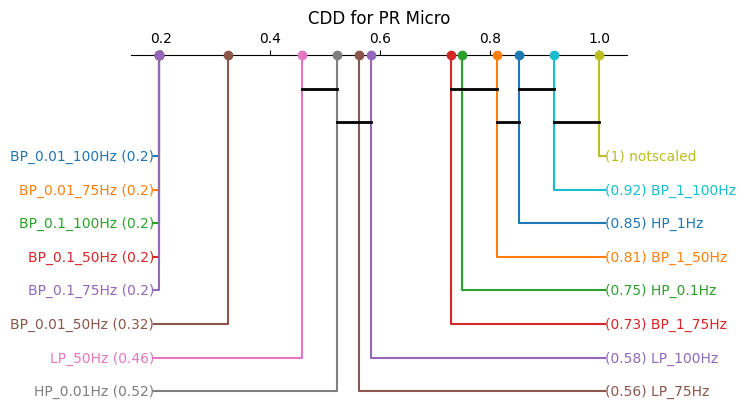

In [27]:
# generate the resutls
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score
import scikit_posthocs as sp

list_condition = list()
list_inter = list()
list_score = list()

metric = 'pr_micro' #['cat_accuracy', 'hamming', 'avg_acc', 'roc_macro', 'roc_micro', 'pr_macro', 'pr_micro']

Y_val = np.load('/media/data1/anolin/Y_val_v1.1.npy').astype(np.int64)
og_labels =  ['Sinusal','Regular','Monomorph','QS complex in V1-V2-V3','R complex in V5-V6','T wave inversion (inferior - II, III, aVF)','Left bundle branch block','RaVL > 11 mm','SV1 + RV5 or RV6 > 35 mm','T wave inversion (lateral -I, aVL, V5-V6)','T wave inversion (anterior - V3-V4)','Left axis deviation','Left ventricular hypertrophy','Bradycardia','Q wave (inferior - II, III, aVF)','Afib','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','Nonspecific intraventricular conduction delay','Premature ventricular complex','Polymorph','T wave inversion (septal- V1-V2)','Right bundle branch block','Ventricular paced','ST elevation (anterior - V3-V4)','ST elevation (septal - V1-V2)','1st degree AV block','Premature atrial complex','Atrial flutter',"rSR' in V1-V2",'qRS in V5-V6-I, aVL','Left anterior fascicular block','Right axis deviation','2nd degree AV block - mobitz 1','ST depression (inferior - II, III, aVF)','Acute pericarditis','ST elevation (inferior - II, III, aVF)','Low voltage','Regularly irregular','Bifid','Junctional rhythm','Left atrial enlargement','ST elevation (lateral - I, aVL, V5-V6)','Atrial paced','Right ventricular hypertrophy','Delta wave','Wolff-Parkinson-White (Pre-excitation syndrome)','Prolonged QT','ST depression (anterior - V3-V4)','QRS complex negative in III','RaVL + SV3 > 28 mm (H) or 20 mm (F)','Q wave (lateral- I, aVL, V5-V6)','Hyperacute T wave (lateral, V5-V6)','Hyperacute T wave (septal, V1-V2)','Supraventricular tachycardia','ST downslopping','ST depression (lateral - I, avL, V5-V6)','2nd degree AV block - mobitz 2','U wave','ST depression et T inversion in V5 or V6','Large >0.08 s','R/S ratio in V1-V2 >1','RV1 + SV6\xa0> 11 mm','Left posterior fascicular block','Right atrial enlargement','ST depression (septal- V1-V2)','Q wave (septal- V1-V2)','Q wave (anterior - V3-V4)','Hyperacute T wave (anterior, V3-V4)','ST upslopping','Right superior axis','Auricular bigeminy','Ventricular tachycardia','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Lead misplacement','Biphasic','Ventricular bigeminy','J wave','Tall >2.5 mm','Third Degree AV Block','Sinus Pause','Acute MI','Early repolarization','Q wave (posterior - V7-V9)','Bi-atrial enlargement','LV pacing','Dextrocardia','Brugada','Ventricular Rhythm','ST depression (posterior - V7-V8-V9)','no_qrs']
to_remove_labels = ['ST depression (posterior - V7-V8-V9)','Tall >2.5 mm', 'J wave', 'Auricular bigeminy', 'Ventricular bigeminy', 'Sinus Pause', 'Dextrocardia', 'Hyperacute T wave (lateral, V5-V6)', 'Hyperacute T wave (septal, V1-V2)', 'Hyperacute T wave (anterior, V3-V4)', 'Bifid', 'RaVL + SV3 > 28 mm (H) or 20 mm (F)', 'Large >0.08 s', 'Biphasic', 'ST depression et T inversion in V5 or V6']

Y_val = np.load('/media/data1/anolin/Y_val_v1.1.npy').astype(np.int64)

pos_to_drop = list()
new_label_names = list()
for pos, item in enumerate(og_labels):
    if item in to_remove_labels:
        pos_to_drop.append(pos)
    else:
        new_label_names.append(item)
Y_val = np.delete(Y_val, pos_to_drop, axis=1)

dict_eq = {42:0,1997:1,2023:2}

for low_cut in [1, 0.1, 0.01, -1]: 
    for high_cut in [100, 75, 50, -1]:
        if low_cut == high_cut == -1:
            continue

        for seed in [42, 1997, 2023]:

            output_matrix = np.load(f"/volume/my_name/resnet50_filtered_{low_cut}_{high_cut}_{seed}_v1.1/output_1.npy")


            sigmoid_v = np.vectorize(sigmoid)
            Y_pred = sigmoid_v(output_matrix)
            sigmoid_v_bin =  np.where(Y_pred > 0.5, 1, 0)
            sigmoid_v_bin

            if low_cut != -1 and high_cut != -1:
                name_condition = f'BP_{low_cut}_{high_cut}Hz'

            elif low_cut == -1 and high_cut != -1:
                name_condition = f'LP_{high_cut}Hz'

            elif low_cut != -1 and high_cut == -1:
                name_condition = f'HP_{low_cut}Hz'

            else:
                pass


            if metric == 'cat_accuracy':
                list_condition.append(name_condition)
                list_inter.append(dict_eq[seed])
                list_score.append(accuracy_score(Y_val, sigmoid_v_bin))

            if metric == 'hamming':
                list_condition.append(name_condition)
                list_inter.append(dict_eq[seed])
                list_score.append(accuracy_score(Y_val, sigmoid_v_bin))
            
            if metric == 'avg_acc':
                list_condition.append(name_condition)
                list_inter.append(dict_eq[seed])
                list_score.append(mean([accuracy_score(Y_val[:,i], sigmoid_v_bin[:,i]) for i in range(Y_val.shape[1])]))

            if metric == 'roc_macro':
                list_condition.append(name_condition)
                list_inter.append(dict_eq[seed])
                list_score.append(roc_auc_score(Y_val, sigmoid_v_bin, average='macro'))            
                                    
            if metric == 'roc_micro':
                list_condition.append(name_condition)
                list_inter.append(dict_eq[seed])
                list_score.append(roc_auc_score(Y_val, sigmoid_v_bin, average='micro'))          


            if metric == 'pr_macro':
                list_condition.append(name_condition)
                list_inter.append(dict_eq[seed])
                list_score.append(average_precision_score(Y_val, sigmoid_v_bin, average='macro'))          

            if metric == 'pr_micro':
                list_condition.append(name_condition)
                list_inter.append(dict_eq[seed])
                list_score.append(average_precision_score(Y_val, sigmoid_v_bin, average='micro'))     
    
df_ = pd.DataFrame(zip(list_condition,list_inter,list_score), columns=['method','fold','score'])
df_ = pd.concat([df_, df_first[df_first.method == 'notscaled']])
avg_rank = df_.groupby('fold').score.rank(pct=True).groupby(df_.method).mean()
test_results = sp.posthoc_conover_friedman(
    df_,
    melted=True,
    block_col='fold',
    group_col='method',
    y_col='score',
)
#sp.sign_plot(test_results)
#plt.title("Conover test PR Macro")
sp.critical_difference_diagram(avg_rank, test_results)
plt.title("CDD for PR Micro")

Text(0.5, 1.0, 'CDD for Acc')

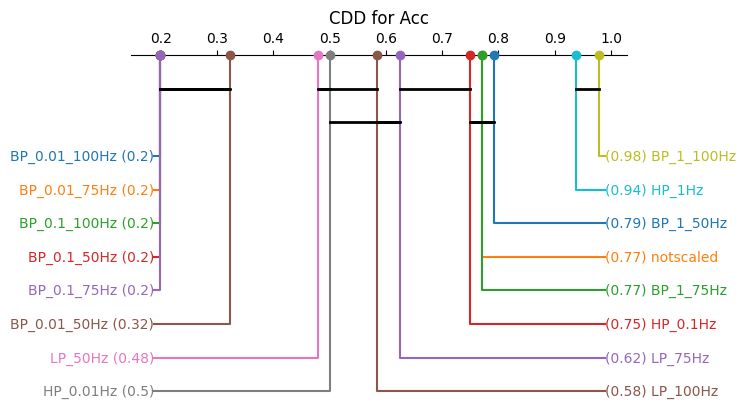

In [22]:
avg_rank = df_.groupby('fold').score.rank(pct=True).groupby(df_.method).mean()
test_results = sp.posthoc_conover_friedman(
    df_,
    melted=True,
    block_col='fold',
    group_col='method',
    y_col='score',
)
#sp.sign_plot(test_results)
#plt.title("Conover test PR Macro")
sp.critical_difference_diagram(avg_rank, test_results)
plt.title("CDD for Acc")

In [3]:
#generate the datasets
list_condition = list()
list_inter = list()
list_score = list()



for file in tqdm(['X_val'], desc='levels'):

    X_val = np.load(f'/media/data1/anolin/{file}_v1.1.npy').astype(np.float16)

    for low_cut in [1, 0.1, 0.01, -1]: 
        for high_cut in [100, 75, 50, -1]:

            print(f'low_cut: {low_cut}Hz')
            print(f'high_cut: {high_cut}Hz')

            if low_cut == -1 and high_cut == -1:
                continue

            # Bandpass filter parameters
            lowcut = low_cut  # Define your own lowcut frequency
            highcut = high_cut  # Define your own highcut frequency
            fs = 250  # Sampling frequency
            order = 2  # Filter order
            N = X_val.shape[0] # Replace with your actual N

            # Create bandpass filter coefficients
            if lowcut == -1:
                b, a = butter(order, highcut, btype='low', fs=fs)

            elif highcut == -1:
                b, a = butter(order, lowcut, btype='high', fs=fs)

            else:
                b, a = butter(order, [lowcut,highcut], btype='bandpass', fs=fs)

            def apply_filter(data_slice):
                """Applies the bandpass filter to a slice of the data."""
                filtered_slice = np.empty_like(data_slice).astype(np.float16)
                for i in range(data_slice.shape[0]):
                    for j in range(data_slice.shape[-1]):
                        filtered_slice[i, :, j] = filtfilt(b, a, data_slice[i, :, j])
                return filtered_slice

            # Divide data into chunks for parallel processing
            num_processes = cpu_count()
            chunk_size = N // num_processes
            chunks = [X_val[i:i + chunk_size].astype(np.float16) for i in range(0, N, chunk_size)]

            # Perform parallel processing with progress tracking
            with Pool(num_processes) as pool:
                results = list(tqdm(pool.imap(apply_filter, chunks), total=len(chunks)))

            # Reassemble the results
            filtered_data = np.concatenate(results, axis=0).astype(np.float16)

            np.save(f'/media/data1/anolin/{file}_filtered_{low_cut}_{high_cut}_v1.1.npy', filtered_data.astype(np.float16))
            gc.collect()
                        

levels:   0%|          | 0/1 [00:00<?, ?it/s]

low_cut: 1Hz
high_cut: 100Hz


100%|██████████| 129/129 [01:13<00:00,  1.76it/s]


low_cut: 1Hz
high_cut: 75Hz


100%|██████████| 129/129 [00:34<00:00,  3.79it/s]


low_cut: 1Hz
high_cut: 50Hz


100%|██████████| 129/129 [00:41<00:00,  3.10it/s]


low_cut: 1Hz
high_cut: -1Hz


100%|██████████| 129/129 [00:28<00:00,  4.56it/s]


low_cut: 0.1Hz
high_cut: 100Hz


100%|██████████| 129/129 [00:25<00:00,  5.11it/s]


low_cut: 0.1Hz
high_cut: 75Hz


100%|██████████| 129/129 [00:30<00:00,  4.21it/s]


low_cut: 0.1Hz
high_cut: 50Hz


100%|██████████| 129/129 [00:30<00:00,  4.18it/s]


low_cut: 0.1Hz
high_cut: -1Hz


100%|██████████| 129/129 [00:29<00:00,  4.36it/s]


low_cut: 0.01Hz
high_cut: 100Hz


100%|██████████| 129/129 [00:29<00:00,  4.32it/s]


low_cut: 0.01Hz
high_cut: 75Hz


100%|██████████| 129/129 [00:41<00:00,  3.11it/s]


low_cut: 0.01Hz
high_cut: 50Hz


100%|██████████| 129/129 [00:42<00:00,  3.05it/s]


low_cut: 0.01Hz
high_cut: -1Hz


100%|██████████| 129/129 [00:38<00:00,  3.34it/s]


low_cut: -1Hz
high_cut: 100Hz


100%|██████████| 129/129 [00:40<00:00,  3.21it/s]


low_cut: -1Hz
high_cut: 75Hz


100%|██████████| 129/129 [01:11<00:00,  1.79it/s]


low_cut: -1Hz
high_cut: 50Hz


levels: 100%|██████████| 1/1 [35:11<00:00, 2111.55s/it]

low_cut: -1Hz
high_cut: -1Hz


In [13]:
import numpy as np
from scipy.signal import butter, filtfilt

# Bandpass filter parameters
lowcut = 0.01  # Define your own lowcut frequency
highcut = 100  # Define your own highcut frequency
fs = 250  # Sampling frequency
order = 2  # Filter order
N = X_val.shape[0] # Replace with your actual N

# Create bandpass filter coefficients
b, a = butter(order, lowcut, btype='highpass', fs=fs)

def apply_filter(data_slice):
    """Applies the bandpass filter to a slice of the data."""
    filtered_slice = np.empty_like(data_slice).astype(np.float16)
    for i in range(data_slice.shape[0]):
        for j in range(data_slice.shape[-1]):
            filtered_slice[i, :, j] = filtfilt(b, a, data_slice[i, :, j])
    return filtered_slice

# Divide data into chunks for parallel processing
num_processes = cpu_count()
chunk_size = N // num_processes
chunks = [X_val[i:i + chunk_size].astype(np.float16) for i in range(0, N, chunk_size)]

# Perform parallel processing with progress tracking
with Pool(num_processes) as pool:
    results = list(tqdm(pool.imap(apply_filter, chunks), total=len(chunks)))

# Reassemble the results
filtered_data = np.concatenate(results, axis=0)

 36%|███▌      | 46/129 [01:10<02:07,  1.54s/it]
